In [1]:
#importing the necessary directories
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split

In [2]:
# Set dataset paths
potato_train_path = "/kaggle/input/mask-original-train-test/segmentation/potato_train"
potato_test_path = "/kaggle/input/mask-original-train-test/segmentation/potato_test"
masked_train_path = "/kaggle/input/mask-original-train-test/segmentation/masked_train"
masked_test_path = "/kaggle/input/mask-original-train-test/segmentation/masked_test"

In [16]:
#Creating the kaggle output directory to store the predictions
import os

# Define the base directory
base_dir = "/kaggle/working"
segmentation_folder = "segmentation"
subfolders = ["E_B", "L_B", "Healthy"]

# Create the root segmentation folder
segmentation_path = os.path.join(base_dir, segmentation_folder)
if not os.path.exists(segmentation_path):
    os.makedirs(segmentation_path)

# Create the subfolders inside the segmentation folder
for subfolder in subfolders:
    subfolder_path = os.path.join(segmentation_path, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

print(f"Output folder '{segmentation_path}' with subfolders {subfolders} created successfully.")


Output folder '/kaggle/working/segmentation' with subfolders ['E_B', 'L_B', 'Healthy'] created successfully.


In [4]:
# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 200

In [5]:
# Function to load images
def load_images(folder):
    images = []
    for subfolder in ["E_B", "L_B", "Healthy"]:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in sorted(os.listdir(subfolder_path)):
            if filename.endswith(".jpg") or filename.endswith(".JPG"):
                img_path = os.path.join(subfolder_path, filename)
                img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img_array)
    return np.array(images)

In [6]:
#Same as the load_images function, but this accepts a single path image given as input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

def load_image_from_path(image_path):
    """
    Load and preprocess a single image given its full path.

    Args:
        image_path (str): Path to the single image file.

    Returns:
        np.array: Preprocessed image as a numpy array.
    """
    # Validate the file path
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"The file '{image_path}' does not exist.")

    # Load the image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Resize to target size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

In [7]:
# load masks for red foreground in the images
# Load masks for foreground in the images
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

IMG_HEIGHT = 256  # Set your image height
IMG_WIDTH = 256   # Set your image width

def load_masks(folder):
    masks = []
    for subfolder in ["E_B", "L_B", "Healthy"]:
        subfolder_path = os.path.join(folder, subfolder)
        for filename in sorted(os.listdir(subfolder_path)):
            if filename.endswith(".jpg") or filename.endswith(".JPG"):
                mask_path = os.path.join(subfolder_path, filename)
                mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
                mask_array = img_to_array(mask)

                # Identify foreground pixels (any pixel other than [0, 0, 0])
                foreground = np.any(mask_array != [0, 0, 0], axis=-1)

                # Convert to binary mask (1 for foreground, 0 for background)
                binary_mask = np.where(foreground, 1, 0)
                #print(binary_mask)

                masks.append(binary_mask)

    return np.array(masks)

In [8]:
# Load datasets
print("Loading training images and masks...")
train_images = load_images(potato_train_path)
train_masks = load_masks(masked_train_path)

print("Loading testing images and masks...")
test_images = load_images(potato_test_path)
test_masks = load_masks(masked_test_path)


Loading training images and masks...
Loading testing images and masks...


In [9]:
# Define U-Net model

def unet_model():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contracting path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)

    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


Initializing the U-Net model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Training the U-Net model...
Epoch 1/200


I0000 00:00:1732451364.610420      75 service.cc:145] XLA service 0x7b8564087230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732451364.610476      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732451405.829239      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6894 - loss: 0.8225 - val_accuracy: 0.5186 - val_loss: 1.2177
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - accuracy: 0.8049 - loss: 0.4286 - val_accuracy: 0.5341 - val_loss: 0.9486
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - accuracy: 0.8432 - loss: 0.3627 - val_accuracy: 0.5382 - val_loss: 1.1304
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - accuracy: 0.8640 - loss: 0.3202 - val_accuracy: 0.5572 - val_loss: 1.1902
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.8786 - loss: 0.2885 - val_accuracy: 0.5549 - val_loss: 1.2299
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - accuracy: 0.8865 - loss: 0.2702 - val_accuracy: 0.5473 - val_loss: 1.3239
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.8871 - loss: 0.2661 - val_accuracy: 0.5543 - val_loss: 1.9109
Epoch 8/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.8886 - loss: 0.2619 - val_accuracy: 0

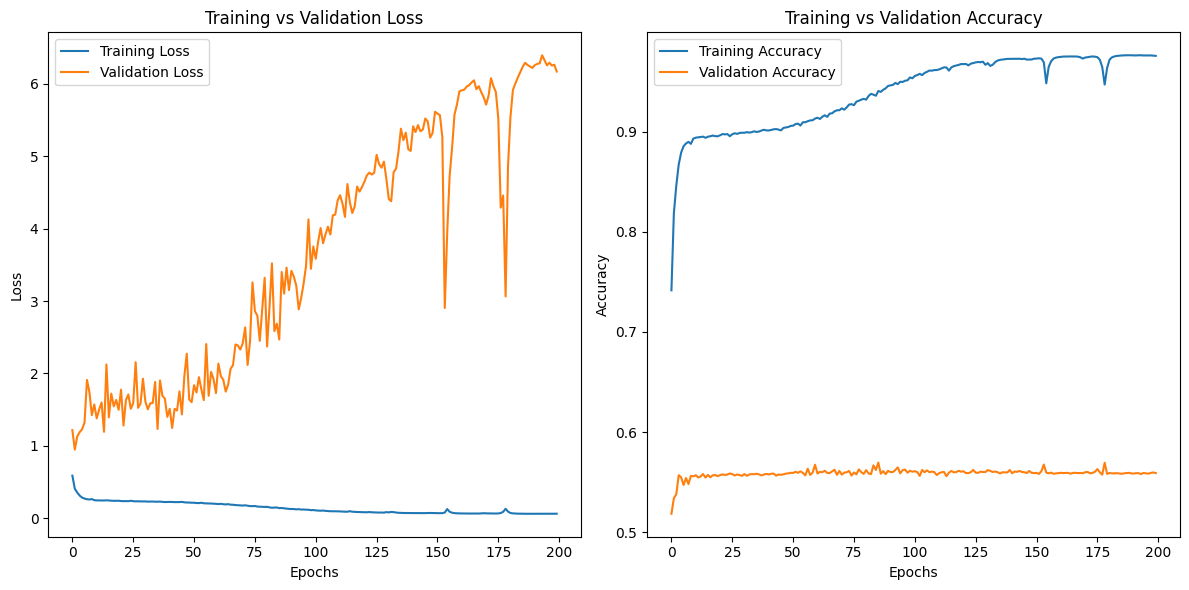

In [11]:
#training the model
import matplotlib.pyplot as plt

# Initialize and train the model
print("Initializing the U-Net model...")
model = unet_model()
model.summary()

print("Training the U-Net model...")
history = model.fit(
    train_images, train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1
)

# Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
#Creating the kaggle output directory to store the predictions
import os

# Define the base directory
base_dir = "/kaggle/working"
segmentation_folder = "segmentation1"
subfolders = ["E_B", "L_B", "Healthy"]

# Create the root segmentation folder
segmentation_path = os.path.join(base_dir, segmentation_folder)
if not os.path.exists(segmentation_path):
    os.makedirs(segmentation_path)

# Create the subfolders inside the segmentation folder
for subfolder in subfolders:
    subfolder_path = os.path.join(segmentation_path, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

print(f"Output folder '{segmentation_path}' with subfolders {subfolders} created successfully.")


Output folder '/kaggle/working/segmentation1' with subfolders ['E_B', 'L_B', 'Healthy'] created successfully.


In [33]:
#creating the directory for saving the model
import os

# Define the base directory
base_dir = "/kaggle/working"
model_folder = "model_weights"
model_filename = "unet_model.weights.h5"

# Create the model folder if it doesn't exist
model_path = os.path.join(base_dir, model_folder)
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Save the model weights to the correct path
model.save_weights(os.path.join(model_path, model_filename))
print(f"Model weights saved as '{os.path.join(model_path, model_filename)}'")


Model weights saved as '/kaggle/working/model_weights/unet_model.weights.h5'


In [38]:
#code to save download the weights from output folder
!zip -r model.zip /kaggle/working/model_weights
from IPython.display import FileLink
FileLink(r'model.zip')

  adding: kaggle/working/model_weights/ (stored 0%)
  adding: kaggle/working/model_weights/unet_model.weights.h5 (deflated 7%)


/kaggle/working/model.zip

In [42]:
#defining the function to get an array of the test image paths
import os
from tensorflow.keras.preprocessing.image import array_to_img

 # Output path for segmented results
output_path = "/kaggle/working/segmentation1"

def get_test_image_paths(base_folder):
     """
     Collect all image paths from subfolders (E_B, L_B, Healthy) in the base folder.
     Args:
         base_folder: The root folder containing subfolders E_B, L_B, and Healthy.
     Returns:
         A list of file paths to all test images.
     """
     paths = []
     for subfolder in ["E_B", "L_B", "Healthy"]:
         subfolder_path = os.path.join(base_folder, subfolder)
         if os.path.isdir(subfolder_path):  # Ensure it is a valid directory
             for filename in sorted(os.listdir(subfolder_path)):
                 if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                     paths.append(os.path.join(subfolder_path, filename))
         else:
             raise NotADirectoryError(f"Expected directory but found: {subfolder_path}")
     return paths

In [43]:
#Function to save the predictions
def save_segmented_results(potato_test_folder, model, output_path):
     """
     Predict and save segmented results into appropriate subfolders.
     Args:
         potato_test_folder: Root folder containing test images in subfolders.
         model: Trained U-Net model.
         output_path: Base path where predictions will be saved.
     """
     # Get all test image paths from the potato_test folder
     test_image_paths = get_test_image_paths(potato_test_folder)

     # Create the output subfolders if they do not exist
     for subfolder in ["E_B", "L_B", "Healthy"]:
         os.makedirs(os.path.join(output_path, subfolder), exist_ok=True)

     # Iterate over all test images and save predictions
     for img_path in test_image_paths:
         # Load the image using the custom load_image function
         img = load_image_from_path(img_path)  # Assuming this function loads an image as a numpy array

         # Predict the mask
         prediction = model.predict(img[np.newaxis, ...])  # Add batch dimension
         prediction = (prediction[0, :, :, 0] > 0.5).astype(np.uint8)  # Threshold to binary mask

         # Convert the binary prediction back to an image
         segmented_image = array_to_img(prediction[..., np.newaxis])

         # Determine the subfolder based on the original image path
         if "E_B" in img_path:
             subfolder = "E_B"
         elif "L_B" in img_path:
             subfolder = "L_B"
         elif "Healthy" in img_path:
             subfolder = "Healthy"
         else:
             raise ValueError(f"Unknown category in path: {img_path}")

         # Save the segmented image to the appropriate subfolder
         filename = os.path.basename(img_path)
         save_path = os.path.join(output_path, subfolder, filename)
         segmented_image.save(save_path)

     print("Segmented results saved successfully!")



In [45]:
 # Example usage:
 # Define the path to the potato_test folder
 potato_test_folder = "/kaggle/input/mask-original-train-test/segmentation/potato_test"  # Update this path accordingly

 # Call the function to save segmented results
 save_segmented_results(potato_test_folder, model, output_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [46]:
#code to save AND download the output folder from kaggle output file
!zip -r segmentation1.zip /kaggle/working/segmentation1
from IPython.display import FileLink
FileLink(r'segmentation1.zip')

  adding: kaggle/working/segmentation1/ (stored 0%)
  adding: kaggle/working/segmentation1/L_B/ (stored 0%)
  adding: kaggle/working/segmentation1/L_B/0170_df919a28-9f11-42f6-823c-15f70bf1325e___RS_LB 4936.JPG (deflated 7%)
  adding: kaggle/working/segmentation1/L_B/0055_1a5f4258-21df-4334-a933-2ef073c932ba___RS_LB 3089.JPG (deflated 9%)
  adding: kaggle/working/segmentation1/L_B/0167_04fe5855-ec9c-40b3-9893-ca8addc236bd___RS_LB 4913.JPG (deflated 12%)
  adding: kaggle/working/segmentation1/L_B/0118_c77d14df-faac-47e9-97e1-fc84a7aa6e74___RS_LB 4322.JPG (deflated 11%)
  adding: kaggle/working/segmentation1/L_B/0025_e4735c8f-e6da-46a1-b0fe-b1d2355a1bd4___RS_LB 2796.JPG (deflated 8%)
  adding: kaggle/working/segmentation1/L_B/0001_b89a9e11-b184-4b4d-bc56-5f27a2626982___RS_LB 2512.JPG (deflated 18%)
  adding: kaggle/working/segmentation1/L_B/0186_e26ad557-11c8-44fd-aad1-dea51c613742___RS_LB 5115.JPG (deflated 4%)
  adding: kaggle/working/segmentation1/L_B/0044_6148bead-5236-461d-90ca-bc552

/kaggle/working/segmentation1.zip

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
Mean IoU: 0.5197
Mean Dice Coefficient: 0.6840
Pixel Accuracy: 0.8504

Classification Report:
                precision    recall  f1-score   support

Background (0)       0.87      0.93      0.90  20893769
Foreground (1)       0.76      0.62      0.68   7352247

      accuracy                           0.85  28246016
     macro avg       0.82      0.78      0.79  28246016
  weighted avg       0.84      0.85      0.85  28246016



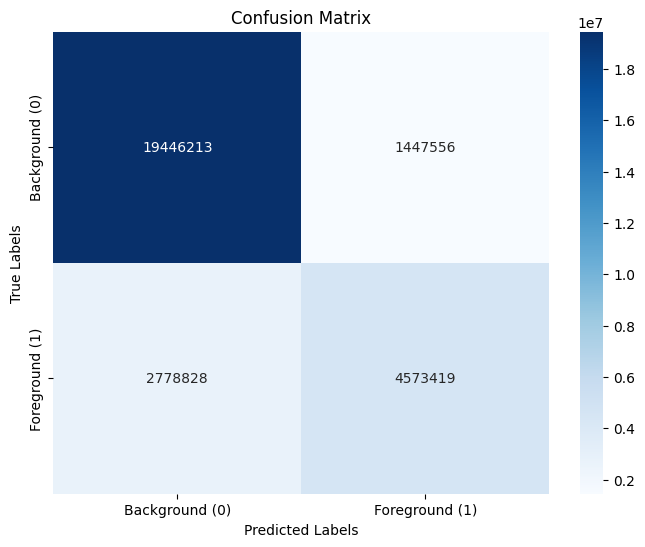

In [22]:
#CODE FOR PRINTING METRICS
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """
    Calculate Mean IoU, Dice Coefficient, and Pixel Accuracy using confusion matrix elements.
    Args:
        y_true: Ground truth binary masks.
        y_pred: Predicted binary masks.
    Returns:
        mean_iou: Mean Intersection over Union.
        dice_coeff: Dice coefficient.
        pixel_accuracy: Pixel accuracy.
    """
    # Flatten arrays for metrics computation
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1]).ravel()

    # Compute metrics
    mean_iou = tp / (tp + fp + fn + 1e-7)  # Avoid division by zero
    dice_coeff = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    pixel_accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-7)

    return mean_iou, dice_coeff, pixel_accuracy

def compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks):
    """
    Compute metrics and plot the confusion matrix for a segmentation model.
    Args:
        model: Trained segmentation model.
        test_images: Array of test images.
        test_masks: Ground truth masks for test images.
    """
    # Predict on the test images
    predictions = model.predict(test_images)

    # Convert predictions and masks to binary (Foreground: 1, Background: 0)
    predicted_masks = (predictions > 0.5).astype(np.uint8)
    test_masks_binary = (test_masks > 0.5).astype(np.uint8)

    # Flatten arrays for confusion matrix and metrics computation
    predicted_masks_flat = predicted_masks.flatten()
    test_masks_binary_flat = test_masks_binary.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(test_masks_binary_flat, predicted_masks_flat)

    # Calculate metrics
    mean_iou, mean_dice_coeff, pixel_accuracy = calculate_metrics(test_masks_binary, predicted_masks)

    # Print metrics
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice_coeff:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_masks_binary_flat, predicted_masks_flat, target_names=["Background (0)", "Foreground (1)"]))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Background (0)", "Foreground (1)"], yticklabels=["Background (0)", "Foreground (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage with model, test_images, and test_masks
compute_metrics_and_plot_confusion_matrix(model, test_images, test_masks)
